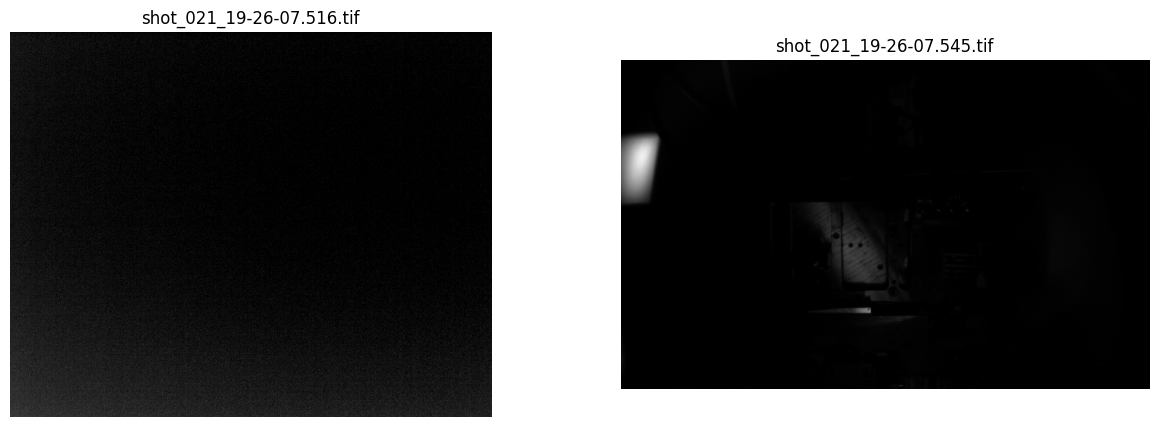

No new images for 5 seconds, exiting...


In [15]:
import os
import time
import threading
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from watchdog.observers import Observer
from watchdog.events import FileSystemEventHandler
from IPython.display import display, clear_output

# Read configuration
with open('sebs_watchdog_config.json', 'r') as f:
    config = json.load(f)

# Paths and configuration
saveroot = config['saveroot']
print(saveroot)
num_images = config['num_images']
folders = [os.path.join(saveroot, subfolder) for subfolder in ['Interferometry2Red','FluorescenceCam']]

# Function to load a 12-bit TIFF image using OpenCV
def load_tiff_image(file_path):
    image = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)
    if image is None:
        raise ValueError(f"Image at {file_path} could not be loaded")
    if image.dtype != np.uint16:
        raise ValueError("Expected 12-bit TIFF images with uint16 data type")
    return (image / 4095.0 * 255).astype(np.uint8)  # Normalize to 8-bit

# Function to plot images with titles
def plot_images(images, paths):
    clear_output(wait=True)
    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))
    for ax, img, path in zip(axs, images, paths):
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        ax.set_title(os.path.basename(path))  # Set the filename as the title
    plt.show()

# Custom event handler to handle new file creations and update latest images
class NewFileHandler(FileSystemEventHandler):
    def __init__(self, folder, latest_images, lock):
        self.folder = folder
        self.latest_images = latest_images
        self.lock = lock

    def on_created(self, event):
        if not event.is_directory and event.src_path.endswith(".tif"):
            with self.lock:
                self.latest_images[self.folder] = event.src_path

# Function to start monitoring a folder
def monitor_folder(folder, latest_images, lock):
    event_handler = NewFileHandler(folder, latest_images, lock)
    observer = Observer()
    observer.schedule(event_handler, folder, recursive=False)
    observer.start()
    try:
        while True:
            time.sleep(1)
    except KeyboardInterrupt:
        observer.stop()
    observer.join()

# Initialize latest images and locks for each folder
latest_images = {folder: None for folder in folders}
locks = {folder: threading.Lock() for folder in folders}
current_displayed = {folder: None for folder in folders}  # Track the current displayed images

# Start folder monitoring in separate threads
threads = []
for folder in folders:
    thread = threading.Thread(target=monitor_folder, args=(folder, latest_images, locks[folder]))
    thread.start()
    threads.append(thread)

# Load initial images from each folder
for folder in folders:
    folder_files = sorted([os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.tif')],
                          key=os.path.getmtime, reverse=True)
    if folder_files:
        latest_image = load_tiff_image(folder_files[0])
        current_displayed[folder] = (latest_image, folder_files[0])

# Initial display
if all(current_displayed.values()):
    images, paths = zip(*current_displayed.values())
    plot_images(list(images), list(paths))

indiv_timeout = 5 #5s timeout
# Continuously update the plot with new images
start_time = time.time()
try:
    while time.time() - start_time < indiv_timeout:
        updated = False
        new_images = []
        new_paths = []
        for folder, lock in locks.items():
            with lock:
                if latest_images[folder] and latest_images[folder] != current_displayed[folder][1]:
                    image = load_tiff_image(latest_images[folder])
                    new_images.append(image)
                    new_paths.append(latest_images[folder])
                    current_displayed[folder] = (image, latest_images[folder])
                    updated = True

        if updated:
            images, paths = zip(*current_displayed.values())
            plot_images(list(images), list(paths))
            start_time = time.time()  # Reset the timer after new images are plotted

        time.sleep(0.1)
except KeyboardInterrupt:
    pass
finally:
    print("No new images for {} seconds, exiting...".format(indiv_timeout))


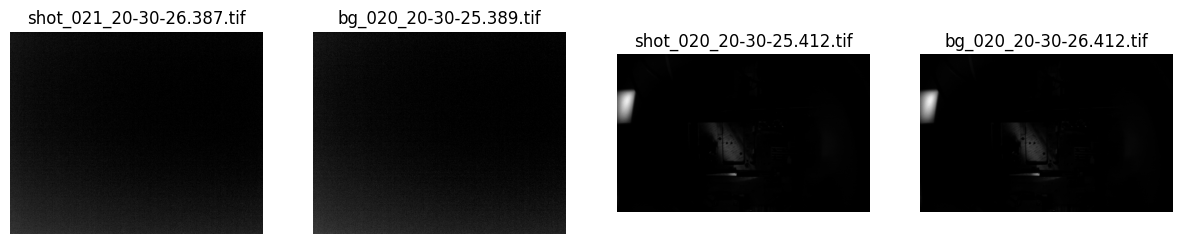

New images displayed.
No new full set of images for 5 seconds, exiting...


In [3]:
import os
import time
import threading
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from watchdog.observers import Observer
from watchdog.events import FileSystemEventHandler
from IPython.display import display, clear_output

# Read configuration
with open('sebs_watchdog_config.json', 'r') as f:
    config = json.load(f)

# Paths and configuration
saveroot = config['saveroot']
folders = [os.path.join(saveroot, subfolder) for subfolder in ['Interferometry2Red', 'FluorescenceCam']]

# Function to load a 12-bit TIFF image using OpenCV
def load_tiff_image(file_path):
    image = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)
    if image is None:
        raise ValueError(f"Image at {file_path} could not be loaded")
    if image.dtype != np.uint16:
        raise ValueError("Expected 12-bit TIFF images with uint16 data type")
    return (image / 4095.0 * 255).astype(np.uint8)  # Normalize to 8-bit

# Function to plot images with titles
def plot_images(images, paths):
    clear_output(wait=True)
    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))
    for ax, img, path in zip(axs, images, paths):
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        ax.set_title(os.path.basename(path))  # Set the filename as the title
    plt.show()

# Custom event handler to handle new file creations and update latest images
class NewFileHandler(FileSystemEventHandler):
    def __init__(self, folder, latest_images, lock):
        self.folder = folder
        self.latest_images = latest_images
        self.lock = lock

    def on_created(self, event):
        if not event.is_directory and event.src_path.endswith(".tif"):
            with self.lock:
                file_type = 'shot' if 'shot' in event.src_path else 'bg' if 'bg' in event.src_path else None
                if file_type:
                    self.latest_images[self.folder][file_type] = event.src_path

# Function to start monitoring a folder
def monitor_folder(folder, latest_images, lock):
    event_handler = NewFileHandler(folder, latest_images, lock)
    observer = Observer()
    observer.schedule(event_handler, folder, recursive=False)
    observer.start()
    try:
        while True:
            time.sleep(1)
    except KeyboardInterrupt:
        observer.stop()
    observer.join()

# Initialize latest images and locks for each folder
latest_images = {folder: {'shot': None, 'bg': None} for folder in folders}
locks = {folder: threading.Lock() for folder in folders}

# Start folder monitoring in separate threads
for folder in folders:
    thread = threading.Thread(target=monitor_folder, args=(folder, latest_images, locks[folder]))
    thread.start()

indiv_timeout = 5  # 5s timeout
start_time = time.time()  # Initialize start time

try:
    last_displayed_images = set()
    while True:
        new_images = []
        new_paths = []
        full_update = True

        for folder, lock in locks.items():
            with lock:
                for img_type in ['shot', 'bg']:
                    image_path = latest_images[folder][img_type]
                    if image_path and image_path not in last_displayed_images:
                        image = load_tiff_image(image_path)
                        new_images.append(image)
                        new_paths.append(image_path)
                    else:
                        full_update = False

        if full_update and new_images:
            plot_images(new_images, new_paths)
            last_displayed_images.update(new_paths)  # Update displayed images set
            start_time = time.time()  # Reset the timer after new images are plotted
            print("New images displayed.")
        elif time.time() - start_time > indiv_timeout:
            print("No new full set of images for 5 seconds, exiting...")
            break

        time.sleep(0.1)
except KeyboardInterrupt:
    print("Keyboard interrupt received, stopping...")


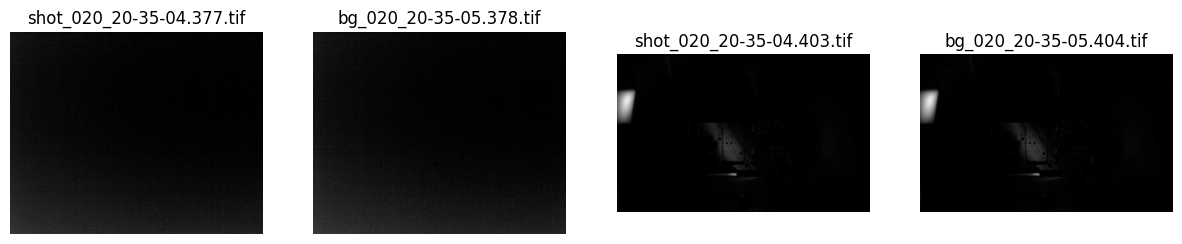

New images displayed.
No new full set of images for 5 seconds, exiting...


In [2]:
import os
import time
import threading
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from watchdog.observers import Observer
from watchdog.events import FileSystemEventHandler
from IPython.display import display, clear_output

# Read configuration
with open('sebs_watchdog_config.json', 'r') as f:
    config = json.load(f)

# Paths and configuration
saveroot = config['saveroot']
folders = [os.path.join(saveroot, subfolder) for subfolder in ['Interferometry2Red', 'FluorescenceCam']]

# Function to load a 12-bit TIFF image using OpenCV
def load_tiff_image(file_path):
    image = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)
    if image is None:
        raise ValueError(f"Image at {file_path} could not be loaded")
    if image.dtype != np.uint16:
        raise ValueError("Expected 12-bit TIFF images with uint16 data type")
    return (image / 4095.0 * 255).astype(np.uint8)  # Normalize to 8-bit

# Function to plot images with titles
def plot_images(images, paths):
    clear_output(wait=True)
    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))
    for ax, img, path in zip(axs, images, paths):
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        ax.set_title(os.path.basename(path))  # Set the filename as the title
    plt.show()

# Custom event handler to handle new file creations and update latest images
class NewFileHandler(FileSystemEventHandler):
    def __init__(self, folder, latest_images, lock):
        self.folder = folder
        self.latest_images = latest_images
        self.lock = lock

    def on_created(self, event):
        if not event.is_directory and event.src_path.endswith(".tif"):
            with self.lock:
                file_type = 'shot' if 'shot' in event.src_path else 'bg' if 'bg' in event.src_path else None
                if file_type:
                    self.latest_images[self.folder][file_type] = event.src_path

# Function to start monitoring a folder
def monitor_folder(folder, latest_images, lock):
    event_handler = NewFileHandler(folder, latest_images, lock)
    observer = Observer()
    observer.schedule(event_handler, folder, recursive=False)
    observer.start()
    try:
        while True:
            time.sleep(1)
    except KeyboardInterrupt:
        observer.stop()
    observer.join()

# Initialize latest images and locks for each folder
latest_images = {folder: {'shot': None, 'bg': None} for folder in folders}
locks = {folder: threading.Lock() for folder in folders}

# Start folder monitoring in separate threads
for folder in folders:
    thread = threading.Thread(target=monitor_folder, args=(folder, latest_images, locks[folder]))
    thread.start()

# Initial setup to find the most recent shot and bg images in each folder
for folder in folders:
    files = os.listdir(folder)
    files = [f for f in files if f.endswith('.tif')]
    shot_file = None
    bg_file = None

    # Find the most recent shot and bg files
    for file in files:
        if 'shot' in file:
            if not shot_file or os.path.getmtime(os.path.join(folder, file)) > os.path.getmtime(os.path.join(folder, shot_file)):
                shot_file = file
        elif 'bg' in file:
            if not bg_file or os.path.getmtime(os.path.join(folder, file)) > os.path.getmtime(os.path.join(folder, bg_file)):
                bg_file = file

    if shot_file and bg_file:
        latest_images[folder]['shot'] = os.path.join(folder, shot_file)
        latest_images[folder]['bg'] = os.path.join(folder, bg_file)

# Check if we can plot the initial set of images
initial_images = []
initial_paths = []
for folder in folders:
    if latest_images[folder]['shot'] and latest_images[folder]['bg']:
        for img_type in ['shot', 'bg']:
            image_path = latest_images[folder][img_type]
            image = load_tiff_image(image_path)
            initial_images.append(image)
            initial_paths.append(image_path)

if initial_images:
    plot_images(initial_images, initial_paths)

indiv_timeout = 5 # 5s timeout
start_time = time.time()

try:
    while True:
        new_images = []
        new_paths = []
        full_update = True

        for folder, lock in locks.items():
            with lock:
                for img_type in ['shot', 'bg']:
                    image_path = latest_images[folder][img_type]
                    if image_path and image_path not in initial_paths:
                        image = load_tiff_image(image_path)
                        new_images.append(image)
                        new_paths.append(image_path)
                    else:
                        full_update = False

        if full_update and new_images:
            plot_images(new_images, new_paths)
            initial_paths = new_paths  # Update the paths of images already plotted
            start_time = time.time()  # Reset the timer after new images are plotted
            print("New images displayed.")
        elif time.time() - start_time > indiv_timeout:
            print("No new full set of images for 5 seconds, exiting...")
            break

        time.sleep(0.1)
except KeyboardInterrupt:
    print("Keyboard interrupt received, stopping...")


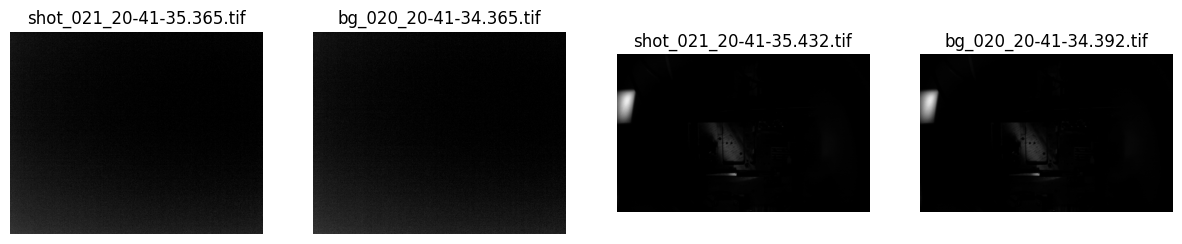

2024-07-05 20:44:36,793 - INFO - New full set of images displayed.
2024-07-05 20:44:41,846 - INFO - No new full set of images for 5 seconds, exiting...
2024-07-05 20:44:41,846 - INFO - Stopped monitoring.


In [8]:
import os
import time
import threading
import json
import cv2
import numpy as np
import logging
import matplotlib.pyplot as plt
from watchdog.observers import Observer
from watchdog.events import FileSystemEventHandler
from IPython.display import display, clear_output

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Read configuration
with open('sebs_watchdog_config.json', 'r') as f:
    config = json.load(f)

# Paths and configuration
saveroot = config['saveroot']
folders = [os.path.join(saveroot, subfolder) for subfolder in ['Interferometry2Red', 'FluorescenceCam']]

# Function to load a 12-bit TIFF image using OpenCV
def load_tiff_image(file_path):
    try:
        image = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)
        if image is None or image.dtype != np.uint16:
            raise ValueError(f"Image at {file_path} is not a 12-bit TIFF image")
        return (image / 4095.0 * 255).astype(np.uint8)  # Normalize to 8-bit
    except Exception as e:
        logging.error(f"Failed to load image {file_path}: {e}")
        return None

# Function to plot images with titles
def plot_images(images, paths):
    clear_output(wait=True)
    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))
    for ax, img, path in zip(axs, images, paths):
        if img is not None:
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            ax.set_title(os.path.basename(path))  # Set the filename as the title
    plt.show()

# Custom event handler to handle new file creations and update latest images
class NewFileHandler(FileSystemEventHandler):
    def __init__(self, folder, latest_images, lock):
        self.folder = folder
        self.latest_images = latest_images
        self.lock = lock

    def on_created(self, event):
        if not event.is_directory and event.src_path.endswith(".tif"):
            with self.lock:
                file_type = 'shot' if 'shot' in event.src_path else 'bg' if 'bg' in event.src_path else None
                if file_type:
                    self.latest_images[self.folder][file_type] = event.src_path
                    logging.info(f"New {file_type} image detected: {event.src_path}")

# Function to start monitoring a folder
def monitor_folder(folder, latest_images, lock):
    event_handler = NewFileHandler(folder, latest_images, lock)
    observer = Observer()
    observer.schedule(event_handler, folder, recursive=False)
    observer.start()
    try:
        while True:
            time.sleep(1)
    except KeyboardInterrupt:
        observer.stop()
    observer.join()

# Initialize latest images and locks for each folder
latest_images = {folder: {'shot': None, 'bg': None} for folder in folders}
locks = {folder: threading.Lock() for folder in folders}

def start_monitoring_folders():
    for folder in folders:
        thread = threading.Thread(target=monitor_folder, args=(folder, latest_images, locks[folder]))
        thread.daemon = True  # Set daemon mode to not block the main thread
        thread.start()

def find_initial_images():
    for folder in folders:
        shot_file, bg_file = None, None
        for file in os.listdir(folder):
            file_path = os.path.join(folder, file)
            if file.endswith('.tif'):
                if 'shot' in file and (not shot_file or os.path.getmtime(file_path) > os.path.getmtime(shot_file)):
                    shot_file = file_path
                elif 'bg' in file and (not bg_file or os.path.getmtime(file_path) > os.path.getmtime(bg_file)):
                    bg_file = file_path
        if shot_file and bg_file:
            latest_images[folder]['shot'] = shot_file
            latest_images[folder]['bg'] = bg_file

def plot_initial_images():
    initial_images = []
    initial_paths = []
    for folder in folders:
        if latest_images[folder]['shot'] and latest_images[folder]['bg']:
            for img_type in ['shot', 'bg']:
                image_path = latest_images[folder][img_type]
                image = load_tiff_image(image_path)
                if image is not None:
                    initial_images.append(image)
                    initial_paths.append(image_path)
    if initial_images:
        plot_images(initial_images, initial_paths)

def main():
    start_monitoring_folders()
    find_initial_images()
    plot_initial_images()

    indiv_timeout = 5  # 5 seconds timeout
    start_time = time.time()
    last_displayed_images = set()

    try:
        while True:
            new_images = []
            new_paths = []
            full_update = True

            for folder, lock in locks.items():
                with lock:
                    for img_type in ['shot', 'bg']:
                        image_path = latest_images[folder][img_type]
                        if image_path and image_path not in last_displayed_images:
                            image = load_tiff_image(image_path)
                            if image is not None:
                                new_images.append(image)
                                new_paths.append(image_path)
                        else:
                            full_update = False

            if full_update and new_images:
                plot_images(new_images, new_paths)
                last_displayed_images.update(new_paths)  # Update displayed images set
                start_time = time.time()  # Reset the timer after new images are plotted
                logging.info("New full set of images displayed.")
            elif time.time() - start_time > indiv_timeout:
                logging.info("No new full set of images for 5 seconds, exiting...")
                break

            time.sleep(0.1)
    except KeyboardInterrupt:
        logging.info("Keyboard interrupt received, stopping...")
    finally:
        logging.info("Stopped monitoring.")

# Run the main function in Jupyter Notebook
main()
